In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as sps
from typing import Callable

## 1.1 Load BTC option data

In [2]:
btc = pd.read_csv("Term_Paper_data-BTC_Option.csv")
btc = btc.drop(['Instrument','volume','delta', 'gamma', 'vega', 'theta', 'rho', 'net_delta'], axis=1)
btc = btc.dropna(subset=['market_price']).reset_index(drop=True)
btc['mid_price'] = 0.5 * (btc.ask_price + btc.bid_price)
btc

,expiration,strike_price,type,open_interest,last_price,bid_iv,bid_price,market_price,ask_price,ask_iv,underlying_price,tau,days,payoff,mid_price
0,10-May-24,44000,C,NaN,NaN,NaN,0.2980,0.2997,0.3025,694.79,62836,0.002740,1,18836,0.30025
1,10-May-24,48000,C,0.3,0.2345,NaN,0.2335,0.2361,0.2385,535.82,62836,0.002740,1,14836,0.23600
2,10-May-24,50000,C,0.5,0.2300,NaN,0.2020,0.2042,0.2075,496.79,62836,0.002740,1,12836,0.20475
3,10-May-24,52000,C,1.4,0.1865,NaN,0.1700,0.1724,0.1750,406.29,62836,0.002740,1,10836,0.17250
4,10-May-24,54000,C,NaN,0.1545,NaN,0.1380,0.1406,0.1440,362.44,62836,0.002740,1,8836,0.14100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,28-Mar-25,220000,P,22.0,2.6280,NaN,NaN,2.2575,NaN,NaN,62836,0.884932,323,157164,NaN
918,28-Mar-25,250000,C,19.2,0.0170,74.73,0.0160,0.0177,0.0195,77.45,62836,0.884932,323,0,0.01775
919,28-Mar-25,250000,P,NaN,NaN,NaN,NaN,2.6931,NaN,NaN,62836,0.884932,323,187164,NaN
920,28-Mar-25,300000,C,142.5,0.0120,77.35,0.0110,0.0124,0.0135,79.91,62836,0.884932,323,0,0.01225


In [3]:
put = btc[btc.type == 'P'].drop(['type'], axis=1).reset_index(drop=True)
put

,expiration,strike_price,open_interest,last_price,bid_iv,bid_price,market_price,ask_price,ask_iv,underlying_price,tau,days,payoff,mid_price
0,10-May-24,59000,277.3,0.0001,93.43,0.0001,0.0001,0.0002,102.89,62836,0.002740,1,0,0.00015
1,10-May-24,60000,581.3,0.0002,71.30,0.0001,0.0002,0.0003,84.50,62836,0.002740,1,0,0.00020
2,10-May-24,60500,0.5,0.0005,60.08,0.0001,0.0002,0.0003,71.72,62836,0.002740,1,0,0.00020
3,10-May-24,61000,528.4,0.0003,54.49,0.0002,0.0003,0.0003,58.70,62836,0.002740,1,0,0.00025
4,10-May-24,61500,198.5,0.0004,45.30,0.0003,0.0004,0.0005,50.75,62836,0.002740,1,0,0.00040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,28-Mar-25,180000,0.2,1.7000,NaN,NaN,1.6823,NaN,NaN,62836,0.884932,323,117164,NaN
462,28-Mar-25,200000,12.8,2.1195,NaN,NaN,1.9687,NaN,NaN,62836,0.884932,323,137164,NaN
463,28-Mar-25,220000,22.0,2.6280,NaN,NaN,2.2575,NaN,NaN,62836,0.884932,323,157164,NaN
464,28-Mar-25,250000,NaN,NaN,NaN,NaN,2.6931,NaN,NaN,62836,0.884932,323,187164,NaN


In [4]:
call = btc[btc.type == 'C'].drop(['type'], axis=1).reset_index(drop=True)
call

,expiration,strike_price,open_interest,last_price,bid_iv,bid_price,market_price,ask_price,ask_iv,underlying_price,tau,days,payoff,mid_price
0,10-May-24,44000,NaN,NaN,NaN,0.2980,0.2997,0.3025,694.79,62836,0.002740,1,18836,0.30025
1,10-May-24,48000,0.3,0.2345,NaN,0.2335,0.2361,0.2385,535.82,62836,0.002740,1,14836,0.23600
2,10-May-24,50000,0.5,0.2300,NaN,0.2020,0.2042,0.2075,496.79,62836,0.002740,1,12836,0.20475
3,10-May-24,52000,1.4,0.1865,NaN,0.1700,0.1724,0.1750,406.29,62836,0.002740,1,10836,0.17250
4,10-May-24,54000,NaN,0.1545,NaN,0.1380,0.1406,0.1440,362.44,62836,0.002740,1,8836,0.14100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,28-Mar-25,180000,33.2,0.0365,71.21,0.0340,0.0360,0.0380,73.16,62836,0.884932,323,0,0.03600
452,28-Mar-25,200000,824.6,0.0280,72.16,0.0265,0.0284,0.0300,74.14,62836,0.884932,323,0,0.02825
453,28-Mar-25,220000,51.8,0.0265,73.33,0.0215,0.0232,0.0250,75.59,62836,0.884932,323,0,0.02325
454,28-Mar-25,250000,19.2,0.0170,74.73,0.0160,0.0177,0.0195,77.45,62836,0.884932,323,0,0.01775


## 1.2 Volatility smile

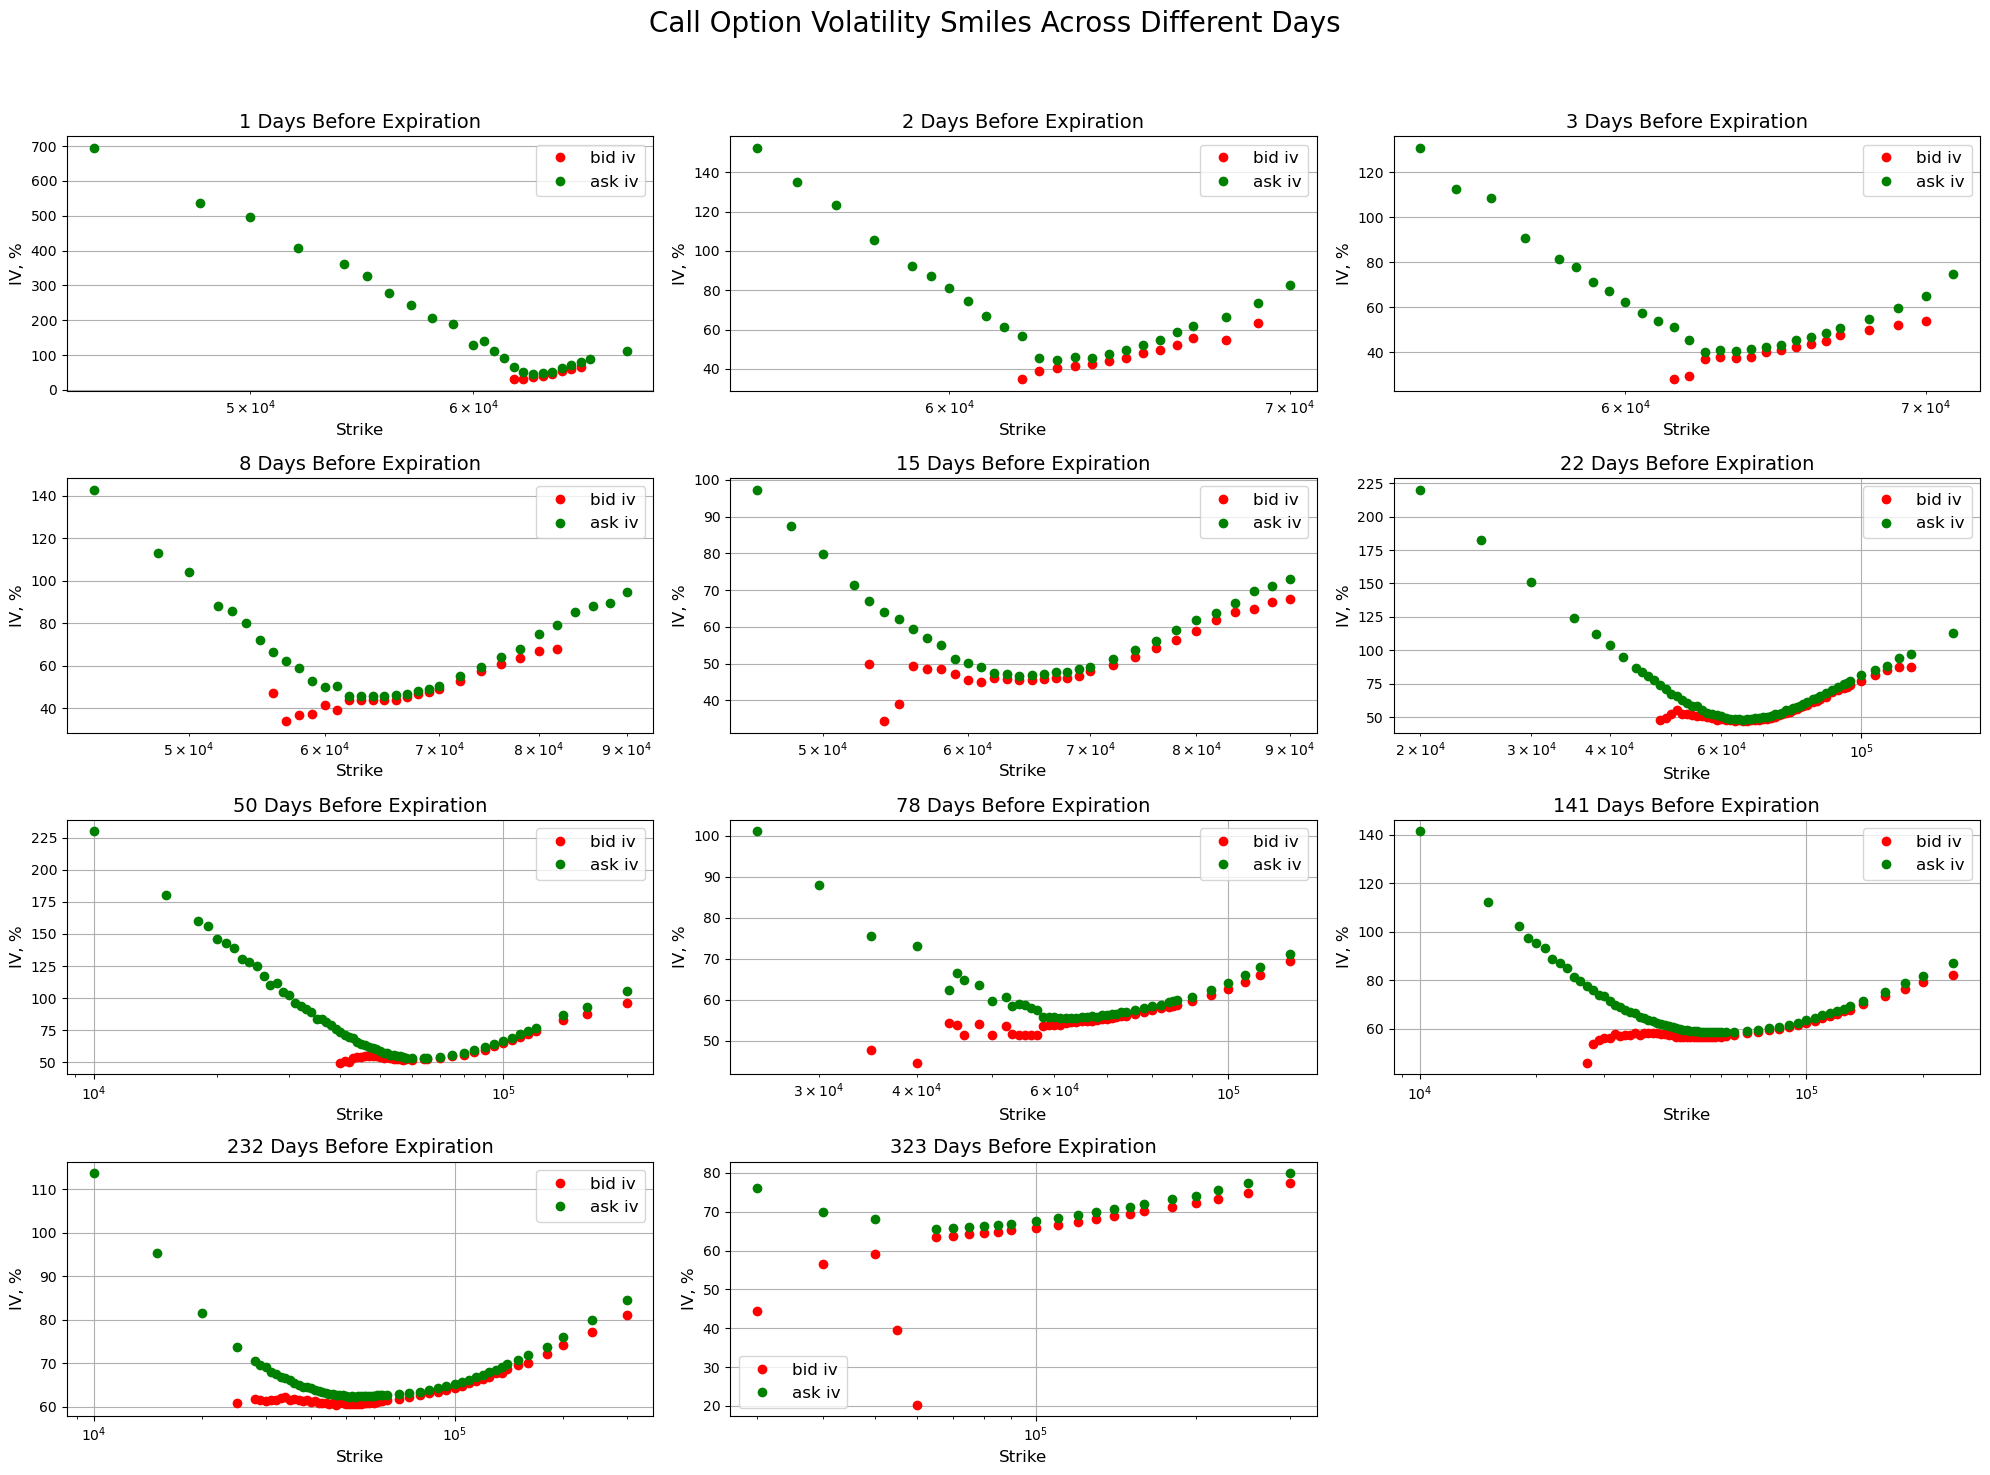

In [5]:
days = set(call.days.values)
rows, cols = 4, 3
fig, axs = plt.subplots(rows, cols, figsize=(20, 15))
fig.suptitle("Call Option Volatility Smiles Across Different Days", fontsize=20)

axs = axs.flatten()

for i, day in enumerate(sorted(days)):
    call_ = call[call.days == day]
    ax = axs[i]
    ax.set_title(f"{day} Days Before Expiration", fontsize=14)
    ax.semilogx(call_.strike_price.values, call_.bid_iv, 'or', label='bid iv')
    ax.semilogx(call_.strike_price.values, call_.ask_iv, 'og', label='ask iv')
    ax.set_ylabel("IV, %", fontsize=12)
    ax.set_xlabel("Strike", fontsize=12)
    ax.legend(fontsize=12)
    ax.grid()

for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

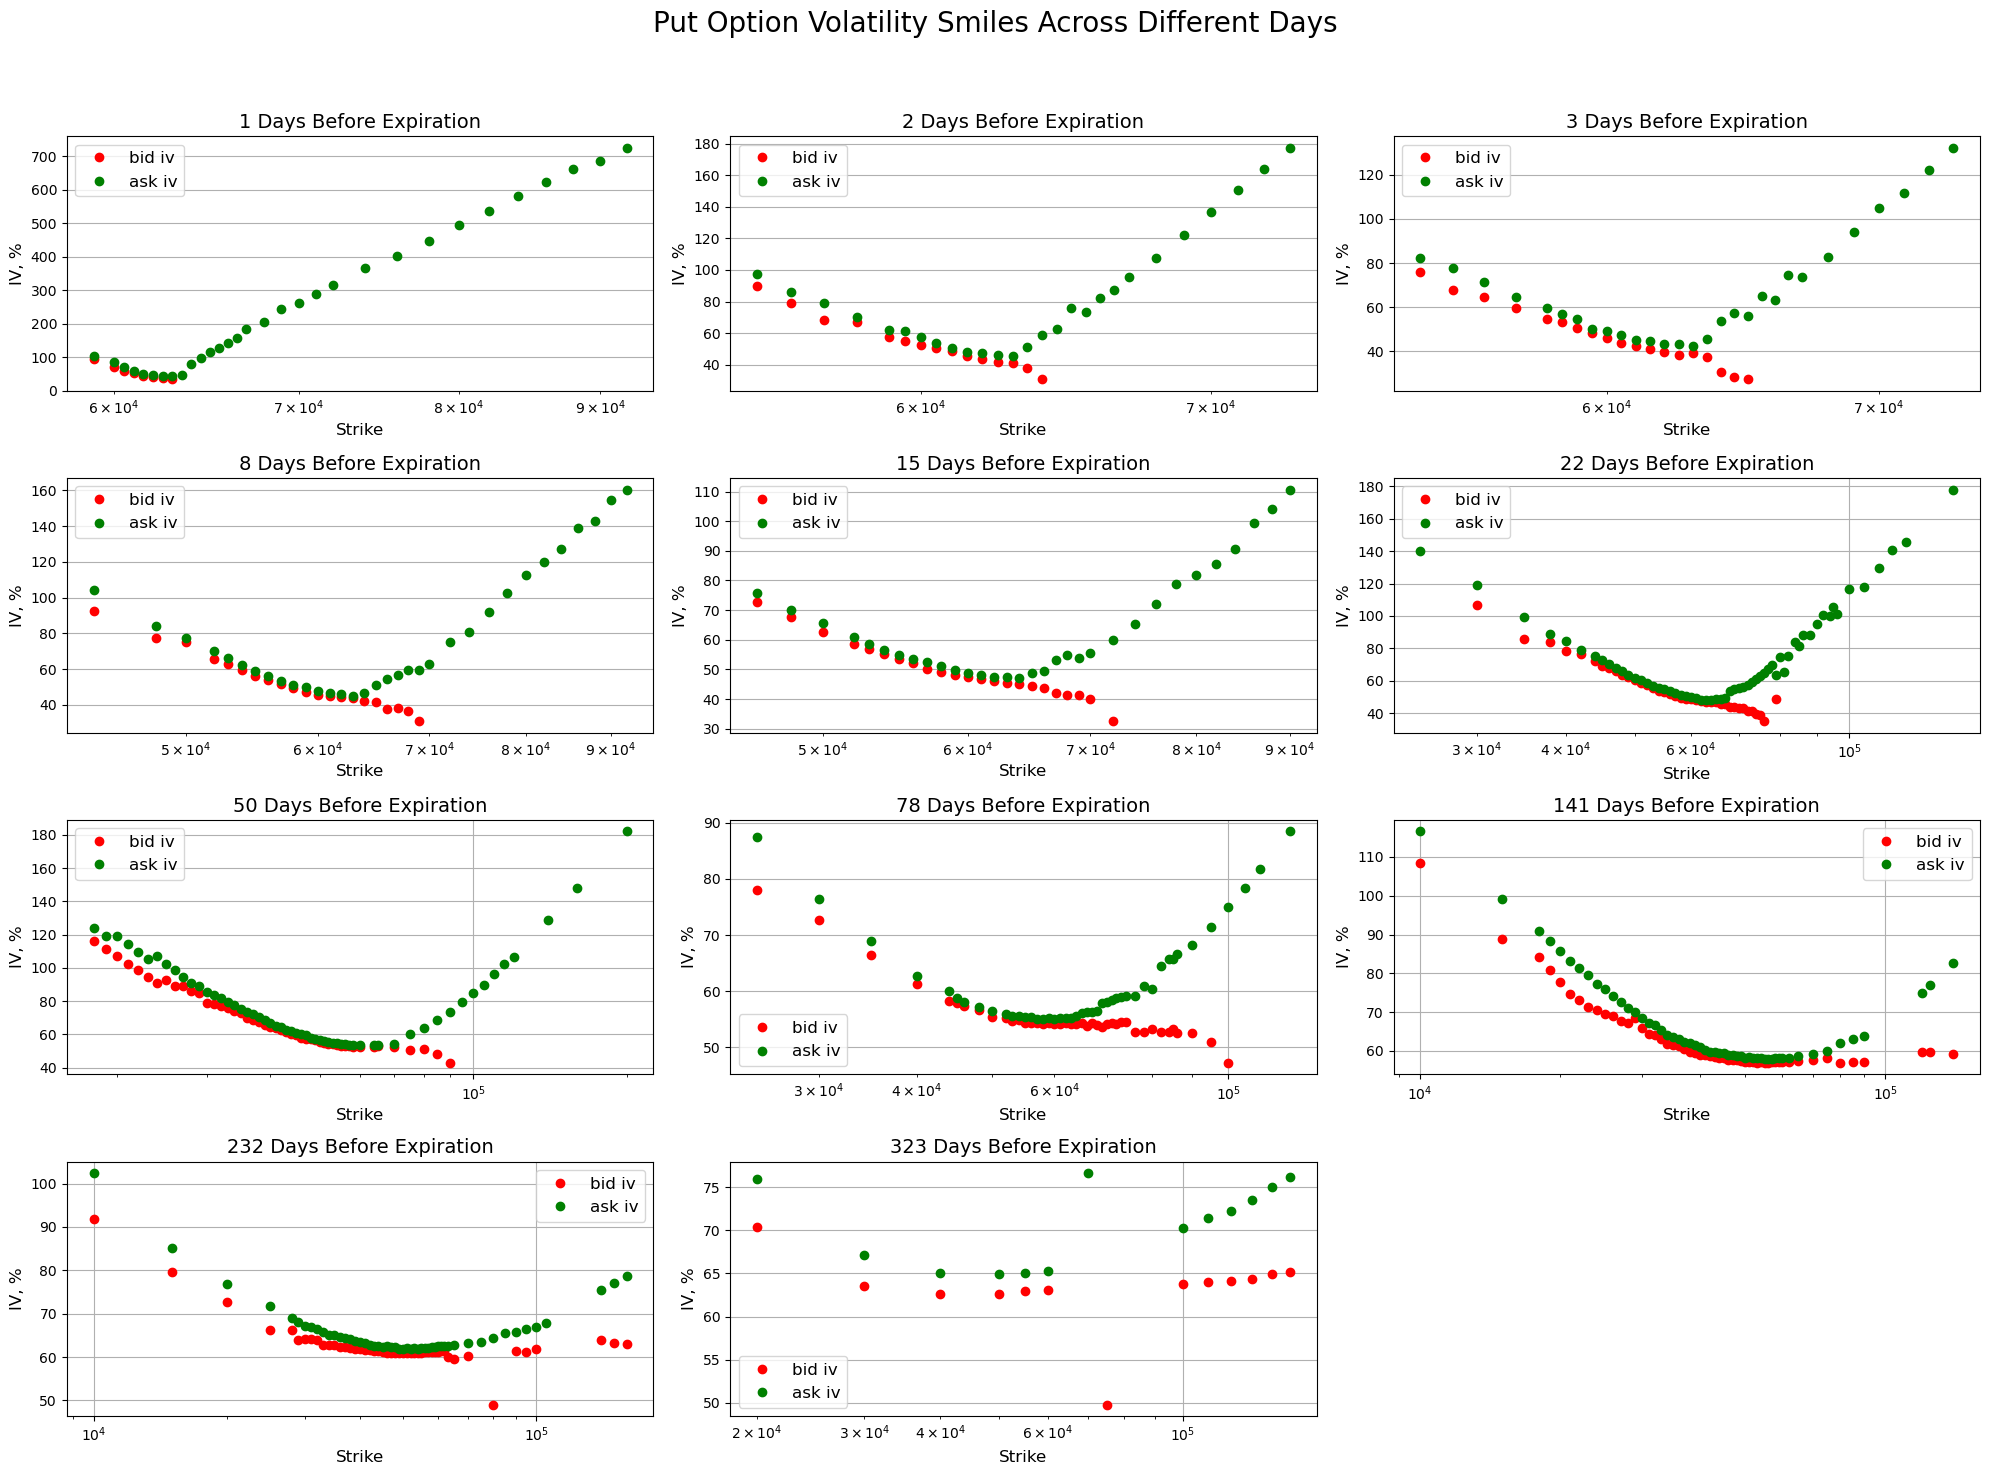

In [6]:
days = set(put.days.values)
rows, cols = 4, 3
fig, axs = plt.subplots(rows, cols, figsize=(20, 15))
fig.suptitle("Put Option Volatility Smiles Across Different Days", fontsize=20)

axs = axs.flatten()

for i, day in enumerate(sorted(days)):
    put_ = put[put.days == day]
    ax = axs[i]
    ax.set_title(f"{day} Days Before Expiration", fontsize=14)
    ax.semilogx(put_.strike_price.values, put_.bid_iv, 'or', label='bid iv')
    ax.semilogx(put_.strike_price.values, put_.ask_iv, 'og', label='ask iv')
    ax.set_ylabel("IV, %", fontsize=12)
    ax.set_xlabel("Strike", fontsize=12)
    ax.legend(fontsize=12)
    ax.grid()

for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 2.1 Methodology: Black-Scholes 

In [7]:
def black_scholes(K, F, T, r, vol):
    d1 = (np.log(F / K) + 0.5 * vol ** 2 * T) / (vol * np.sqrt(T) + 1e-10)
    d2 = d1 - vol * np.sqrt(T)
    D = np.exp(-r * T)
    call_price = D * (F * sps.norm.cdf(d1) - K * sps.norm.cdf(d2))
    return call_price


## 2.2 External Functions

In [8]:
def Hagan_implied_vol(K, F, T, alpha, beta, rho, v):
    F_mid = np.sqrt(F * K)
    r1 = (beta - 1) ** 2 * alpha ** 2 * F_mid ** (2 * beta - 2) / 24
    r2 = rho * beta * alpha * v * F_mid ** (beta - 1) / 4
    r3 = (2 - 3 * rho ** 2) / 24 * v ** 2
    S = 1 + T * (r1 + r2 + r3)
    z = v / alpha * F_mid ** (1 - beta) * np.log(F / K)
    sqrt = np.sqrt(1 - 2 * rho * z + z ** 2)
    X = np.log((sqrt + z - rho) / (1-rho))
    D = F_mid ** (1-beta) * (1 + (beta-1)**2/24 * (np.log(F/K))
                             ** 2 + (beta-1)**4/1920 * (np.log(F/K))**4)

    iv = alpha * S * z / D / X
    return iv

def SABR_Jacobian(K, F, T, alpha, beta, rho, v):
    F_mid = np.sqrt(F * K)
    r1 = (beta - 1) ** 2 * alpha ** 2 * F_mid ** (2 * beta - 2) / 24
    r2 = rho * beta * alpha * v * F_mid ** (beta - 1) / 4
    r3 = (2 - 3 * rho ** 2) / 24 * v ** 2
    S = 1 + T * (r1 + r2 + r3)
    z = v / alpha * F_mid ** (1 - beta) * np.log(F / K)
    sqrt = np.sqrt(1 - 2 * rho * z + z ** 2)
    X = np.log((sqrt + z - rho) / (1-rho))
    D = F_mid ** (1-beta) * (1 + (beta-1)**2/24 * (np.log(F/K))** 2 + (beta-1)**4/1920 * (np.log(F/K))**4)
    iv = alpha * S * z / D / X

    X_z = 1 / sqrt

    S_alpha = T * (2 * r1 + r2) / alpha
    z_alpha = -z / alpha
    X_alpha = X_z * z_alpha

    S_rho = T * v * (beta * alpha * F_mid**(beta - 1) - rho * v) / 4
    X_rho = 1 / (1 - rho) - 1 / sqrt * (sqrt + z) / (sqrt + z - rho)

    S_v = T / v * (r2 + 2 * r3)
    z_v = z / v
    X_v = X_z * z_v

    z_beta = -np.log(F_mid) * z
    X_beta = X_z * z_beta
    S_beta = T * (2 * r1 * (1/(beta-1)+np.log(F_mid)) +
                  r2 * (1/beta + np.log(F_mid)))
    D_beta = -np.log(F_mid) * D + F_mid**(1-beta) * ((beta-1) /
                                                     12 * (np.log(F/K))**2 + (beta-1)**3/480 * (np.log(F/K))**4)

    logs_alpha = 1 / alpha + S_alpha / S + z_alpha / z - X_alpha / X
    logs_v = S_v / S + z_v / z - X_v / X
    logs_beta = S_beta / S - D_beta / D + z_beta / z - X_beta / X
    logs_rho = S_rho / S - X_rho / X

    iv_alpha = iv * logs_alpha
    iv_v = iv * logs_v
    iv_beta = iv * logs_beta
    iv_rho = iv * logs_rho

    return iv, iv_alpha, iv_beta, iv_rho, iv_v

def generate_random_params():
    eps = 1e-5
    alpha = 0.3 * np.random.rand(1) + eps
    v = 1.0 * np.random.rand(1) + eps
    beta = 0.1 + 0.8 * np.random.rand(1)
    rho = -0.9 + (1.8) * np.random.rand(1)
    return np.asarray([alpha[0], beta[0], rho[0], v[0]])


def SABR_proj(sabr_params):
    alpha, beta, rho, v = sabr_params

    eps = 1e-6

    alpha = max(alpha, eps)
    v = max(v, eps)
    rho = np.clip(rho, -1 + eps, 1 - eps)
    beta = np.clip(beta, eps, 1 - eps)

    return np.asarray([alpha, beta, rho, v])


def Levenberg_Marquardt_optimization(Niter, f, proj, x0):

    x = x0.copy()

    mu = 100.0
    nu1 = 2.0
    nu2 = 2.0

    fs = []
    res, J = f(x)
    F = np.linalg.norm(res)

    result = {"xs": [x], "objective": [F], "x": None}

    for i in range(Niter):
        I = np.diag(np.diag(J @ J.T)) + 1e-5 * np.eye(len(x))
        dx = np.linalg.solve(mu * I + J @ J.T, J @ res)
        x_ = proj(x - dx)
        res_, J_ = f(x_)
        F_ = np.linalg.norm(res_)
        if F_ < F:
            x, F, res, J = x_, F_, res_, J_
            mu /= nu1
            result['xs'].append(x)
            result['objective'].append(F)
        else:
            i -= 1
            mu *= nu2
            continue
        eps = 1e-10
        if F < eps:
            break
        result['x'] = x
    return result

## 2.3 SABR

In [9]:
from black_scholes_model import black_scholes
from external_functions import Hagan_implied_vol, SABR_Jacobian, generate_random_params, SABR_proj
from external_functions import Levenberg_Marquardt_optimization
import numpy as np
import matplotlib.pyplot as plt

class SABR:
    def __init__(self, sabr_params=None):
        self.sabr_params = sabr_params

    def fit_iv(self,iv0, K, F, T, Niter= 100, weights=None, sabr_params=None):
        F = np.ones_like(iv0) * F
        T = np.ones_like(iv0) * T
        if weights is None:
            weights = np.ones_like(iv0)
        weights = weights / np.sum(weights)
        if sabr_params is None:
            sabr_params = generate_random_params()

        def get_residals(sabr_params: np.ndarray):
            alpha, beta, rho, v = sabr_params
            iv, iv_alpha, iv_beta, iv_rho, iv_v = SABR_Jacobian(
                K, F, T, alpha, beta, rho, v)
            res = iv - iv0
            J = np.asarray([iv_alpha, iv_beta, iv_rho, iv_v])
            return res * weights, J @ np.diag(weights)

        # optimization
        result = Levenberg_Marquardt_optimization(
            Niter, get_residals, SABR_proj, sabr_params)
        self.sabr_params = result['x']

        return result

    def predict_iv(self, K, F, T):
        iv = Hagan_implied_vol(K, F, T, *self.sabr_params)
        return iv

    def predict_call_price(self, K, F, T):
        vol = self.predict_iv(K, F, T)
        C = black_scholes(K, F, T, 0, vol)
        return C

    def predict_put_price(self, K, F, T):
        C = self.predict_call_price(K, F, T)
        P = C + (K - F)
        return P



## 3.1 Calibration

We'll calibrate volatility surface using only OTM options and then we'll test it on the whole dataset

In [10]:
def OTM_data_from_df(df):

    ind = (df.payoff == 0.0) & (~np.isnan(df.mid_price).values)
    df_ = df[ind].copy().reset_index(drop=True)

    F = df_.underlying_price.values
    K = df_.strike_price.values
    T = df_.tau.values

    iv = 0.5 * (df_.ask_iv.values + df_.bid_iv.values) / 100.0
    C = df_.mid_price.values * F

    return C, iv, K, F, T


def get_calibration_data(put: pd.DataFrame, call: pd.DataFrame):

    data_call = np.stack(OTM_data_from_df(call))
    data_put = np.stack(OTM_data_from_df(put))
    data = np.concatenate((data_call, data_put), axis=-1)
    c, iv, K, F, T = data
    
    return c, iv, K, F, T

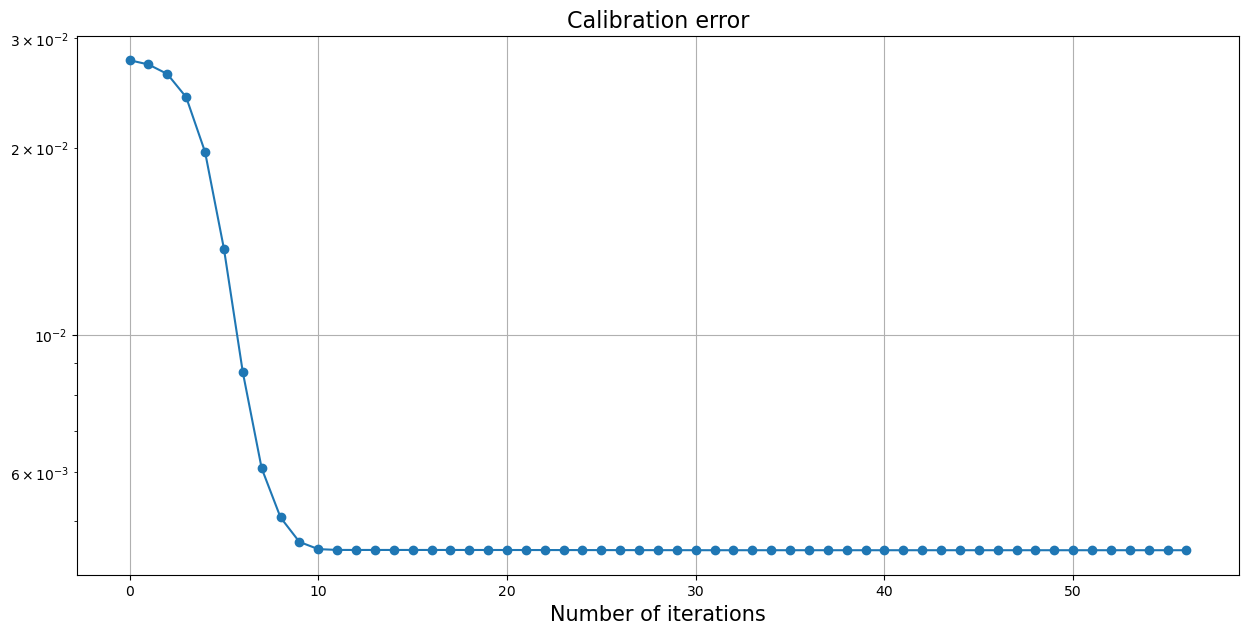

In [11]:
X, iv, K, F, T = get_calibration_data(put, call)
weights = np.ones_like(X)
weights = weights / np.sum(weights)

sabr_model = SABR()
result = sabr_model.fit_iv(iv, K, F, T)
plt.figure(figsize=(15, 7))
plt.title("Calibration error", fontsize=16)
plt.semilogy(result['objective'], '-o')
plt.xlabel("Number of iterations", fontsize=15)
plt.grid()
plt.show()

In [12]:
print(f"alpha: {sabr_model.sabr_params[0].round(6)}")
print(f"beta: {sabr_model.sabr_params[1].round(6)}")
print(f"rho: {sabr_model.sabr_params[2].round(6)}")
print(f"v: {sabr_model.sabr_params[3].round(6)}")

alpha: 0.554071
beta: 0.999999
rho: -0.115894
v: 1.11465


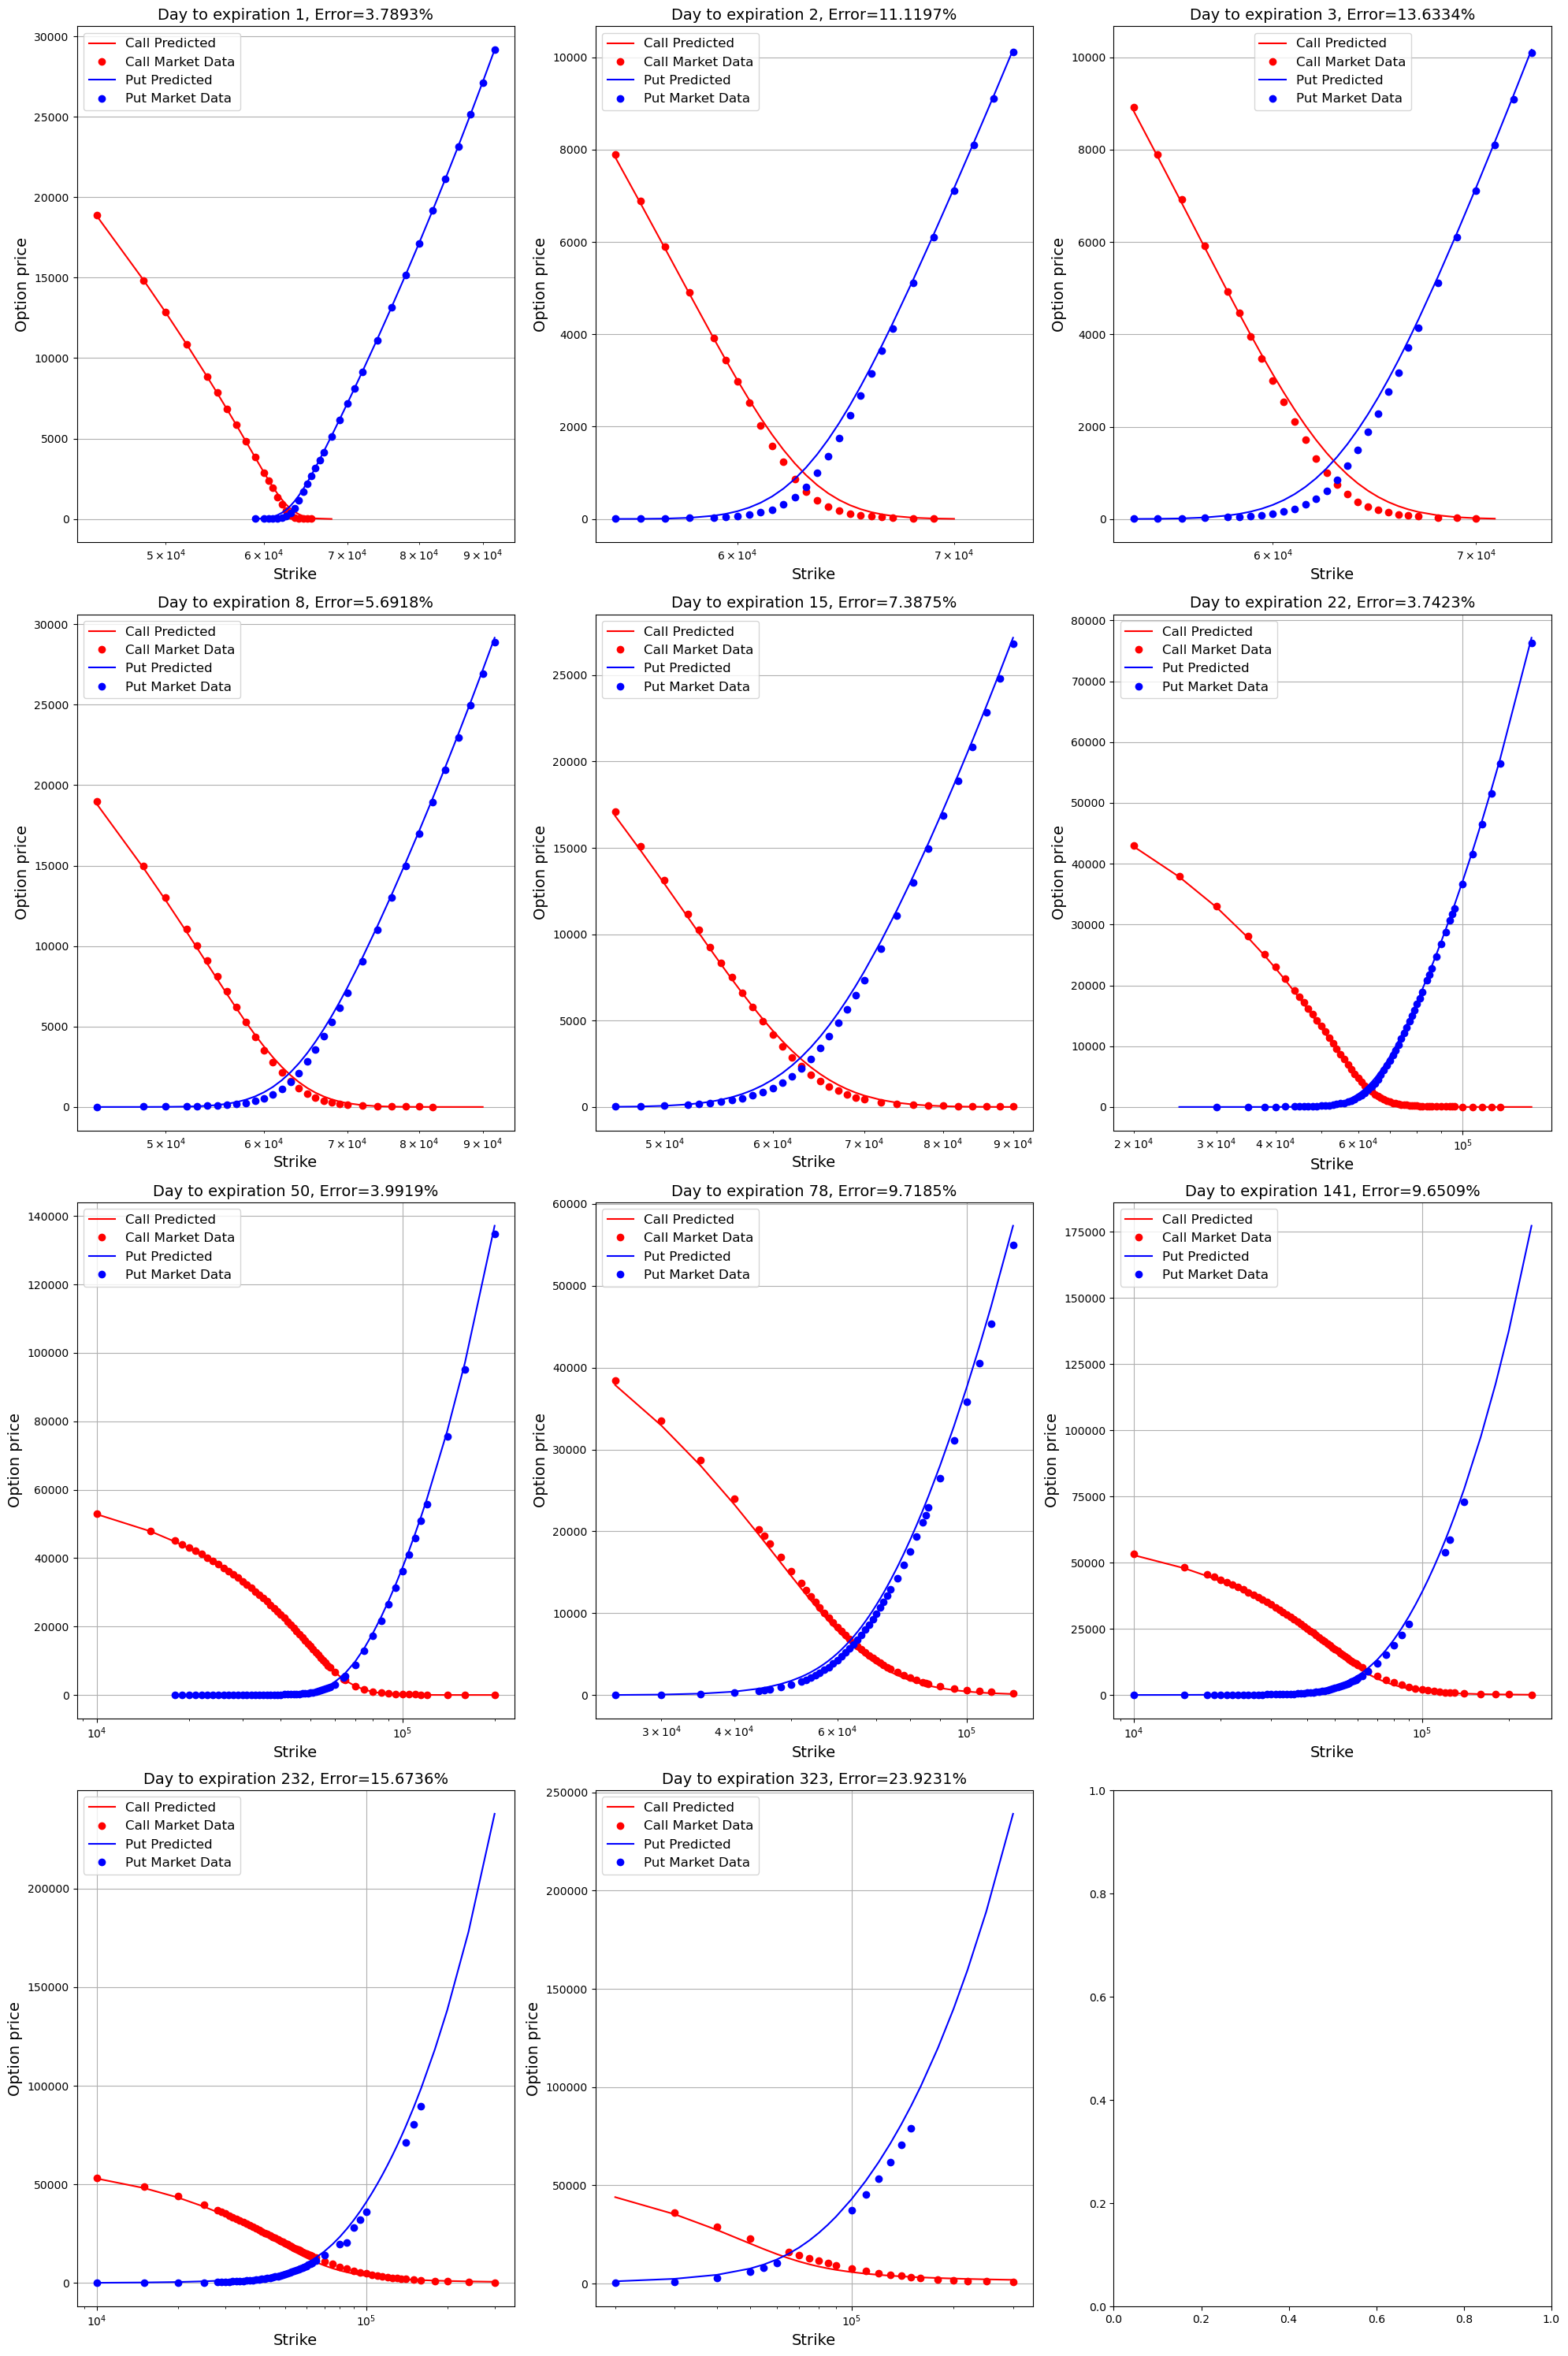

In [18]:
import matplotlib.pyplot as plt

def plot_option_price(call: pd.DataFrame, put: pd.DataFrame, day: float, ax):
    call_ = call[call.days == day]
    put_ = put[put.days == day]

    K_call = call_.strike_price.values
    F_call = call_.underlying_price.values
    T_call = call_.tau.values

    C_predict = sabr_model.predict_call_price(K_call, F_call, T_call)
    C_mid = call_.mid_price.values * F_call
    C_mark = call_.market_price.values * F_call
    error_call = 100 * np.linalg.norm(C_mark - C_predict) / np.linalg.norm(C_mark)

    ax.semilogx(K_call, C_predict, '-r', label='Call Predicted')
    ax.semilogx(K_call, C_mid, 'ro', label='Call Market Data')

    K_put = put_.strike_price.values
    F_put = put_.underlying_price.values
    T_put = put_.tau.values

    P_predict = sabr_model.predict_put_price(K_put, F_put, T_put)
    P_mid = put_.mid_price.values * F_put
    P_mark = put_.market_price.values * F_put
    error_put = 100 * np.linalg.norm(P_mark - P_predict) / np.linalg.norm(P_mark)

    ax.semilogx(K_put, P_predict, '-b', label='Put Predicted')
    ax.semilogx(K_put, P_mid, 'bo', label='Put Market Data')

    ax.legend(fontsize=12)
    ax.set_title(f'Day to expiration {day}, Error={(error_call + error_put):.4f}%', fontsize=14)
    ax.grid(True)

    ax.set_xlabel("Strike", fontsize=14)
    ax.set_ylabel("Option price", fontsize=14)

days = [1, 2, 3, 8, 15, 22, 50, 78, 141, 232, 323]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 30))  
axes = axes.flatten()  

for i, day in enumerate(days):
    if i < len(axes):  
        plot_option_price(call, put, day, axes[i])

plt.tight_layout()
plt.show()
